# Imports and Setup

In [ ]:
import os
import re
from glob import glob
from typing import Dict, Optional
from time import time
import warnings
import yaml

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

import monai
from monai.data import MetaTensor
from monai.networks.utils import one_hot
from monai.transforms import (Compose,CopyItemsd, LabelToMaskd,
                              Lambdad, RandRotate90d, ScaleIntensityd,
                              Rand2DElasticd, RandFlipd, RandGaussianNoised)


from PIL import Image
#from pytorch_lightning.loggers import WandbLogger
from skimage import color

import segmentation_models_pytorch as smp

In [ ]:
# Ign$ore specific deprecation warnings related to TypedStorage
warnings.filterwarnings('ignore', category=UserWarning, message='.*TypedStorage is deprecated.*')

In [ ]:
Image.MAX_IMAGE_PIXELS = None

In [ ]:
data_path="/content/local_data/"

# Setup Datasets, Dataloaders and Augmentations/Transforms

In [ ]:
def make_label_img(annotation_img):
    # Your provided logic to process the mask image
    all_zeros = np.all(annotation_img == 0, axis=2)
    red_channel = annotation_img[:, :, 0] > 0
    label_img = np.full(annotation_img.shape[:2], 2, dtype=int)
    label_img[all_zeros] = 0
    label_img[red_channel] = 1
    return label_img

def process_and_save_labels(annotations_path, labels_np_resized_path):
    # Create the target directory if it doesn't exist
    if not os.path.exists(labels_np_resized_path):
        os.makedirs(labels_np_resized_path)

    # Iterate over mask image files
    for annotation_file in glob(os.path.join(annotations_path, "*.png")):
        # Load the image
        annotation_img = cv2.imread(annotation_file)[:,:,::-1]

        # Process the image
        label_img = make_label_img(annotation_img)

        # Save the processed image as a numpy array
        np.save(os.path.join(labels_np_resized_path, os.path.basename(annotation_file).replace('.png', '')), label_img)

# Usage
annotations_path = data_path + 'annotations_resized'
labels_np_resized_path = data_path+ 'labels_np_resized'
process_and_save_labels(annotations_path, labels_np_resized_path)

In [ ]:
class Dict2Class(object):
    # ToDo: Wrap into RandStainNA
    def __init__(self, my_dict: Dict):
        self.my_dict = my_dict
        for key in my_dict:
            setattr(self, key, my_dict[key])

class RandStainNAd(object):
    def __init__(
        self,
        keys: list,
        yaml_file: str,
        std_hyper: Optional[float] = 0,
        distribution: Optional[str] = "normal",
        probability: Optional[float] = 1.0,
        is_train: Optional[bool] = True,
    ):
        assert distribution in [
            "normal",
            "laplace",
            "uniform",
        ], "Unsupported distribution style {}.".format(distribution)

        self.keys = keys
        self.yaml_file = yaml_file
        cfg = self._get_yaml_data(self.yaml_file)
        c_s = cfg["color_space"]

        self._channel_avgs = {
            "avg": [
                cfg[c_s[0]]["avg"]["mean"],
                cfg[c_s[1]]["avg"]["mean"],
                cfg[c_s[2]]["avg"]["mean"],
            ],
            "std": [
                cfg[c_s[0]]["avg"]["std"],
                cfg[c_s[1]]["avg"]["std"],
                cfg[c_s[2]]["avg"]["std"],
            ],
        }

        self._channel_stds = {
            "avg": [
                cfg[c_s[0]]["std"]["mean"],
                cfg[c_s[1]]["std"]["mean"],
                cfg[c_s[2]]["std"]["mean"],
            ],
            "std": [
                cfg[c_s[0]]["std"]["std"],
                cfg[c_s[1]]["std"]["std"],
                cfg[c_s[2]]["std"]["std"],
            ],
        }

        self.channel_avgs = Dict2Class(self._channel_avgs)
        self.channel_stds = Dict2Class(self._channel_stds)

        self.p = probability
        self.std_adjust = std_hyper
        self.color_space = c_s
        self.distribution = distribution
        self.is_train = is_train

    def _get_yaml_data(self, yaml_file):
        with open(yaml_file, "r", encoding="utf-8") as file:
            data = yaml.load(file, Loader=yaml.FullLoader)
        return data

    def _create_mask(self, image: np.ndarray, threshold: int = 5) -> np.ndarray:
      """Create a binary mask separating the tissue from the background."""
      grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      _, binary_mask = cv2.threshold(grayscale, threshold, 1, cv2.THRESH_BINARY)
      return binary_mask

    def _getavgstd(self, image: np.ndarray, mask: np.ndarray) -> (np.ndarray, np.ndarray):
        avgs = [np.sum(image[:, :, idx] * mask) / np.sum(mask) for idx in range(image.shape[2])]
        masked_image = np.repeat(mask[:, :, np.newaxis], 3, axis=2) * image
        stds = [np.std(masked_image[:, :, idx]) for idx in range(image.shape[2])]
        return np.array(avgs), np.array(stds)

    def _normalize(
        self,
        img: np.ndarray,
        img_avgs: np.ndarray,
        img_stds: np.ndarray,
        tar_avgs: np.ndarray,
        tar_stds: np.ndarray,
    ) -> np.ndarray:

        img_stds = np.clip(img_stds, 0.0001, 255)
        img = (img - img_avgs) * (tar_stds / img_stds) + tar_avgs

        if self.color_space in ["LAB", "HSV"]:
            img = np.clip(img, 0, 255).astype(np.uint8)

        return img

    def _apply_masked_transform(self, image: np.ndarray, mask: np.ndarray, transformed: np.ndarray) -> np.ndarray:
        """Apply the transformation only to the masked region."""
        expanded_mask = np.expand_dims(mask, axis=-1)  # Shape becomes [height, width, 1]
        return image * (1 - expanded_mask) + transformed * expanded_mask


    def augment(self, img):
        # img:is_train:false——>np.array()(cv2.imread()) #BGR
        # img:is_train:True——>PIL.Image #RGB

        if self.is_train == False:
            image = img
        else:
            image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

        mask = self._create_mask(image)

        num_of_channel = image.shape[2]

        # color space transfer
        if self.color_space == "LAB":
            image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        elif self.color_space == "HSV":
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.color_space == "HED":
            image = color.rgb2hed(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        std_adjust = self.std_adjust

        # virtual template generation
        tar_avgs = []
        tar_stds = []
        if self.distribution == "uniform":

            # three-sigma rule for uniform distribution
            for idx in range(num_of_channel):

                tar_avg = np.random.uniform(
                    low=self.channel_avgs.avg[idx] - 3 * self.channel_avgs.std[idx],
                    high=self.channel_avgs.avg[idx] + 3 * self.channel_avgs.std[idx],
                )
                tar_std = np.random.uniform(
                    low=self.channel_stds.avg[idx] - 3 * self.channel_stds.std[idx],
                    high=self.channel_stds.avg[idx] + 3 * self.channel_stds.std[idx],
                )

                tar_avgs.append(tar_avg)
                tar_stds.append(tar_std)
        else:
            if self.distribution == "normal":
                np_distribution = np.random.normal
            elif self.distribution == "laplace":
                np_distribution = np.random.laplace

            for idx in range(num_of_channel):
                tar_avg = np_distribution(
                    loc=self.channel_avgs.avg[idx],
                    scale=self.channel_avgs.std[idx] * (1 + std_adjust),
                )

                tar_std = np_distribution(
                    loc=self.channel_stds.avg[idx],
                    scale=self.channel_stds.std[idx] * (1 + std_adjust),
                )
                tar_avgs.append(tar_avg)
                tar_stds.append(tar_std)

        tar_avgs = np.array(tar_avgs)
        tar_stds = np.array(tar_stds)

        img_avgs, img_stds = self._getavgstd(image, mask)

        transformed_image = self._normalize(
            img=image,
            img_avgs=img_avgs,
            img_stds=img_stds,
            tar_avgs=tar_avgs,
            tar_stds=tar_stds,
        )

        # Now, apply transformation only to tissue regions, keep the black background unchanged
        transformed_image = self._apply_masked_transform(image, mask, transformed_image)

        if self.color_space == "LAB":
            transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_LAB2RGB)
        elif self.color_space == "HSV":
            transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_HSV2BGR)
        elif self.color_space == "HED":
            nimg = color.hed2rgb(transformed_image)
            imin = nimg.min()
            imax = nimg.max()
            rsimg = (255 * (nimg - imin) / (imax - imin)).astype("uint8")  # rescale to [0,255]
            transformed_image = cv2.cvtColor(rsimg, cv2.COLOR_RGB2BGR)

        return transformed_image

    def __call__(self, data):
        # Apply to each key in the self.keys list
        d = dict(data)
        for key in self.keys:
            if np.random.rand(1) < self.p:
                d[key] = self.augment(d[key])
        return d

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        format_string += f"methods=Reinhard"
        format_string += f", colorspace={self.color_space}"
        format_string += f", mean={self._channel_avgs}"
        format_string += f", std={self._channel_stds}"
        format_string += f", std_adjust={self.std_adjust}"
        format_string += f", distribution={self.distribution}"
        format_string += f", p={self.p})"
        return format_string

In [ ]:
# Path to the folders
thumbnails_path = data_path + 'train_thumbnails'
labels_path = data_path + 'labels_np_resized'

# List and sort the files in each folder
thumbnails = sorted(glob(os.path.join(thumbnails_path, "*.png")))
labels = sorted(glob(os.path.join(labels_path, "*.npy")))

# Extract numbers from filenames and store in a set for easy lookup
ids = set(re.search(r'(\d+)', os.path.basename(label)).group(1) for label in labels)

# Filter thumbnails to keep only those that have corresponding masks
thumbnails_filtered = [thumb for thumb in thumbnails if re.search(r'(\d+)_thumbnail', os.path.basename(thumb)).group(1) in ids]

print(len(thumbnails_filtered))
print(len(labels))

152
152


In [ ]:
# Define a function to extract the numeric ID from the filename
def extract_id(filename):
    match = re.search(r'(\d+)', os.path.basename(filename))
    return int(match.group(1)) if match else None

# Sort the lists using the custom sorting key
thumbnails_sorted = sorted(thumbnails_filtered, key=extract_id)
labels_sorted = sorted(labels, key=extract_id)
print(len(thumbnails_sorted))
print(len(labels_sorted))

152
152


In [ ]:
train_files = [{"img": thumb, "label": label} for thumb, label in zip(thumbnails_sorted[:120], labels_sorted[:120])]
val_files = [{"img": thumb, "label": label} for thumb, label in zip(thumbnails_sorted[121:], labels_sorted[121:])]

In [ ]:
def change_background_color(x):
    new_color = torch.tensor([241, 239, 240], dtype=x.dtype, device=x.device)
    # Create a mask for all black pixels across the spatial dimensions H and W
    black_pixels_mask = (x == 0).all(dim=0)
    # Expand the mask to match the number of channels C
    expanded_mask = black_pixels_mask.unsqueeze(0).expand_as(x)
    # Replace black pixels with the new color
    x = torch.where(expanded_mask, new_color[:, None, None], x)
    return x

In [ ]:
# define transforms for image and segmentation
train_transforms = Compose(
    [
        Lambdad(keys=['img'], func=lambda x: Image.open(x)),
        Lambdad(keys=['label'], func=lambda x: np.load(x)),
        RandStainNAd(keys=["img"], yaml_file="/content/local_data/CRC_LAB_randomTrue_n0 (1).yaml", std_hyper=-0.15, distribution="normal", probability=0.9, is_train=True),
        Lambdad(keys=['img'], func=lambda img_np: MetaTensor(img_np) if isinstance(img_np, np.ndarray) else MetaTensor(np.array(img_np))),
        Lambdad(keys=['img'], func=lambda x: x.permute(2,0,1)),
        Lambdad(keys=['label'], func=lambda x: x.unsqueeze(0)),

        CopyItemsd(keys=['label'], times=1, names=['mask']),                                        # Copy label to new image mask
        LabelToMaskd(keys=['mask'], select_labels=[1,2], merge_channels=True, allow_missing_keys=True),
        Lambdad(keys=['img'], func=change_background_color),
        ScaleIntensityd(keys=["img"]),
        monai.transforms.Resized(keys=['img','label', 'mask'], spatial_size=(512, 512)),
        RandRotate90d(keys=["img", "label", "mask"], prob=0.5, spatial_axes=[0, 1]),
        RandFlipd(keys=["img", "label", "mask"], prob=0.3, spatial_axis=0),
        RandFlipd(keys=["img", "label", "mask"], prob=0.3, spatial_axis=1),
        Rand2DElasticd(keys=["img", "label", "mask"],
                       prob=0.5,
                       spacing=(30, 30),
                       magnitude_range=(0, 0.5),
                       rotate_range=(0.2, 0.2),
                       scale_range=(-0.05,0.05),
                       mode="bilinear",
                       padding_mode="reflection"),
        RandGaussianNoised(keys=["img"], prob=0.05, mean=0.0, std=0.1),

    ]
)


val_transforms = Compose(
    [
        Lambdad(keys=['img'], func=lambda x: Image.open(x)),
        Lambdad(keys=['label'], func=lambda x: np.load(x)),
        Lambdad(keys=['img'], func=lambda img_np: MetaTensor(img_np) if isinstance(img_np, np.ndarray) else MetaTensor(np.array(img_np))),
        Lambdad(keys=['img'], func=lambda x: x.permute(2,0,1)),
        Lambdad(keys=['label'], func=lambda x: x.unsqueeze(0)),

        CopyItemsd(keys=['label'], times=1, names=['mask']),                                        # Copy label to new image mask
        LabelToMaskd(keys=['mask'], select_labels=[1,2], merge_channels=True, allow_missing_keys=True),
        Lambdad(keys=['img'], func=change_background_color),
        ScaleIntensityd(keys=["img"]),
        monai.transforms.Resized(keys=['img','label', 'mask'], spatial_size=(512, 512)),
    ]
)

In [ ]:
train_dataset = monai.data.Dataset(data=train_files, transform=train_transforms)
val_dataset = monai.data.Dataset(data=val_files, transform=val_transforms)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
    pin_memory=True,
)

# Setup Model and Training Parametes

In [ ]:
ENCODER = 'resnext50_32x4d'
ENCODER_WEIGHTS = 'swsl'
CLASSES = 2
ACTIVATION = None  # could be None for logits or 'softmax2d' for multiclass segmentation
CHANNELS = (1024, 512, 256, 128, 64)
DEPTH = 5

# create segmentation model with custom modifications
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=CLASSES,
    activation=ACTIVATION,
    encoder_depth = DEPTH,
    decoder_channels =  CHANNELS,
)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6

num_parameters = count_parameters(model)
print(f"Number of parameters: {num_parameters}")

Downloading: "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnext50_32x4-72679e44.pth" to /root/.cache/torch/hub/checkpoints/semi_weakly_supervised_resnext50_32x4-72679e44.pth
100%|██████████| 95.8M/95.8M [00:04<00:00, 20.3MB/s]


Number of parameters: 73.160898


In [ ]:
# Define learning rates
encoder_lr = 5e-5  # Lower learning rate for the pre-trained encoder
decoder_lr = 1e-4  # Higher learning rate for the newly initialized decoder and head

# Separate the encoder and decoder parameters
encoder_params = model.encoder.parameters()
decoder_params = list(model.decoder.parameters()) + list(model.segmentation_head.parameters())

# Create the optimizer with two parameter groups
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': encoder_lr},
    {'params': decoder_params, 'lr': decoder_lr}
])

# Define loss function and gradient scaler for mixed precision training
loss_fn = monai.losses.MaskedDiceLoss(include_background=True)
scaler = torch.cuda.amp.GradScaler()

# Define the cosine annealing learning rate scheduler
T_max = 30  # Define the number of epochs until the learning rate cycles back to its initial value
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=0)

# Training Loop

In [ ]:
model = model.cuda()

NUM_EPOCHS = 100
EVAL_EVERY = 5

print('Starting training')
all_train_losses = []
all_val_losses = []
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    # Training phase
    mean_train_loss = 0
    num_samples = 0
    t0 = time()
    model.train()
    for batch in tqdm(train_loader):
        image_b = batch['img'].cuda(non_blocking=True)
        label = batch['label'].cuda(non_blocking=True)
        mask = batch['mask'].cuda(non_blocking=True)
        label = one_hot(label, num_classes=3)
        label = label[:, 1:]

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            pred = model(image_b)
            loss = loss_fn(input=pred.softmax(dim=1), target=label, mask=mask)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        mean_train_loss += loss.detach().item() * image_b.size(0)
        num_samples += image_b.size(0)

    train_time = time() - t0
    mean_train_loss /= num_samples
    all_train_losses.append(mean_train_loss)

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS} - Train Loss: {mean_train_loss:.4f}, Time: {train_time:.2f}s')

    scheduler.step()

    # Evaluation phase
    if (epoch + 1) % EVAL_EVERY == 0 or (epoch + 1) == NUM_EPOCHS:
        mean_val_loss = 0
        num_samples = 0
        t0 = time()
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_loader):
                image_b = batch['img'].cuda(non_blocking=True)
                label = batch['label'].cuda(non_blocking=True)
                mask = batch['mask'].cuda(non_blocking=True)
                label = one_hot(label, num_classes=3)
                label = label[:, 1:]

                with torch.cuda.amp.autocast():
                    pred = model(image_b)
                    loss = loss_fn(input=pred.softmax(dim=1), target=label, mask=mask)

                mean_val_loss += loss.item() * image_b.size(0)
                num_samples += image_b.size(0)

        val_time = time() - t0
        mean_val_loss /= num_samples
        all_val_losses.append(mean_val_loss)

        # Checkpointing
        if mean_val_loss < best_val_loss:
            print(f'Saving best model checkpoint - Epoch {epoch + 1}, Val Loss: {mean_val_loss:.4f}')
            best_val_loss = mean_val_loss
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scaler': scaler.state_dict(),
                'epoch': epoch,
                'train_losses': all_train_losses,
                'val_losses': all_val_losses,
                'best_val_loss': best_val_loss,
            }, '/content/drive/MyDrive/models/UBC_seg_models/model_checkpoint_0.pth')

        print(f'Epoch {epoch + 1}/{NUM_EPOCHS} - Val Loss: {mean_val_loss:.4f}, Time: {val_time:.2f}s')

# Plot Loss Curves and Segmentation Output on Validation Images

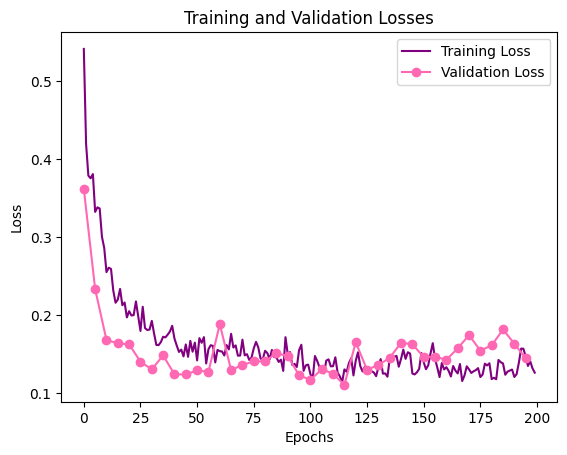

In [ ]:
# Validation every 5 epochs
validation_epochs = [i * 5 for i in range(len(all_val_losses))]

# Define colors
training_color = 'purple'  # Purple color
validation_color = '#FF69B4'  # Pinkish color (Hex for 'Hot Pink')

# Plot training losses with purple color
plt.plot(all_train_losses, label='Training Loss', color=training_color)

# Plot validation losses with pinkish color, 
plt.plot(validation_epochs, all_val_losses, label='Validation Loss', marker='o', color=validation_color)

# Adding title and labels
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adding a legend to distinguish between the two lines
plt.legend()

# Display the plot
plt.savefig('segmentaion_loss_curves')
plt.show()

In [ ]:
sample = next(iter(val_loader))

In [ ]:
preds = model(sample['img'].cuda())

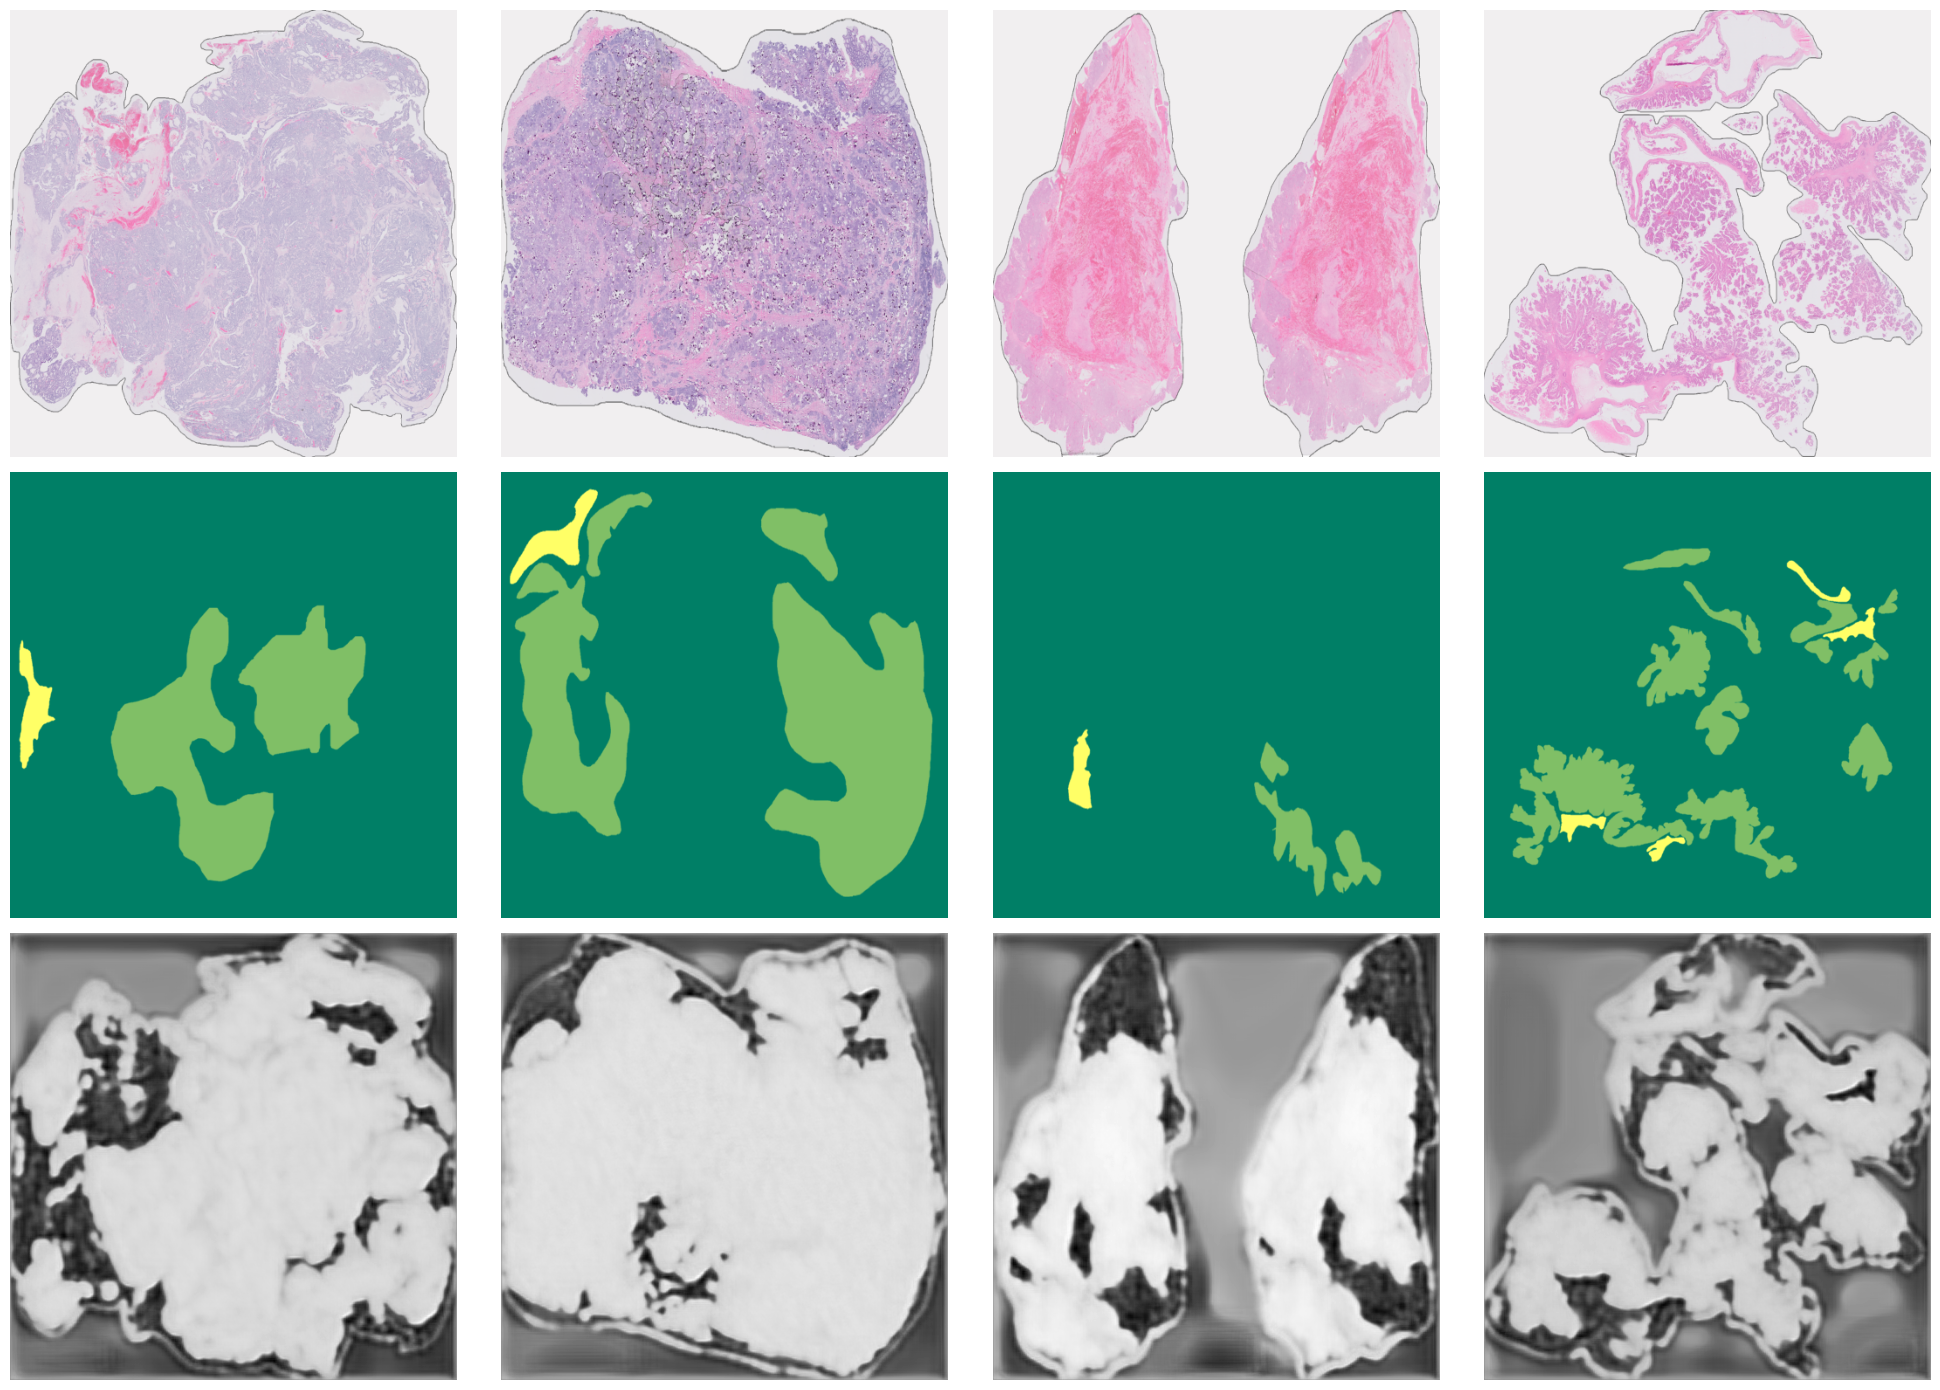

In [ ]:
# Function to display a single item (image, label, or mask)
def display_item(ax, item_tensor, cmap='gray'):
    if item_tensor.shape[0] == 1:
        # For single-channel items, use a grayscale colormap
        ax.imshow(item_tensor[0], cmap=cmap)
    else:
        # For multi-channel items, permute the tensor to match matplotlib's expectation
        ax.imshow(item_tensor.permute(1, 2, 0))
    ax.axis('off')

# Number of samples in the batch
num_samples = 4  # Assuming 8 samples for images, labels, and masks

# Create a figure with subplots
fig, axs = plt.subplots(3, num_samples, figsize=(20, 14))  # 3 rows for image, label, mask

# Check if the tensors are on a GPU and if so, move them to the CPU
if sample['img'].is_cuda:
    images = sample['img'].cpu()
    labels = sample['label'].cpu()
    masks = sample['mask'].cpu()
else:
    images = sample['img']
    labels = sample['label']
    masks = sample['mask']

# Display images, labels, and masks
for i in range(num_samples):
    display_item(axs[0, i], images[4+i])  # Display images in the first row
    display_item(axs[1, i], labels[4+i], cmap='summer')  # Display labels in the second row
    display_item(axs[2, i], preds[4+i][0].unsqueeze(0).detach().cpu())   # Display masks in the third row

plt.tight_layout()
plt.show()